

## Problem 3 [20 Points]


Consider the Helmholtz equation in one dimension:

$$\frac{\partial^{2}}{\partial{x}^2}u(x) - \gamma u(x) = f(x), \ \ x\in[-1,1].$$

The exact solution for this problem is $u(x) = \sin(\pi x)$, corresponding to $f(x) = -\pi^2 \sin(\pi x) - \gamma \sin(\pi x)$. First, consider $\gamma = 5\sqrt{2}$ and generate a training data-set $\{X_u,y_u\}$ and $\{X_f,y_f\}$ by sampling the exact solution for $u(x)$ and $f(x)$, respectively. Specifically, use $N_u=3$ and $N_f=10$ data points sampled randomly on a Latin Hypercube grid.

Then use this data-set to train the following Gaussian process model in order to predict the underlying functions $u(x)$ and $f(x)$, as well as to learn the unknown parameter $\gamma$:

$u(x)\sim\mathcal{GP}(0, k(x,x', \theta)), \qquad f(x)\sim\mathcal{GP}(0, g(x,x';\theta, \gamma))$,

where $g(x,x';\theta, \gamma) = \mathcal{L}_{x}^{\gamma}\mathcal{L}^{\gamma}_{x'}k(x,x';\theta)$, $\mathcal{L}_{x}^{\gamma}:= \frac{\partial^{2}}{\partial{x}^2} - \gamma$, and  $k(x,x';\theta)$ is the standard RBF kernel. Use symbolic calculations to construct the necessary kernels and note how $\gamma$ becomes a kernel hyper-parameter for  $g(x,x';\theta, \gamma)$ ([reference](https://www.sciencedirect.com/science/article/pii/S0021999117305582)). Plot your predictions for $u(x)$ and $f(x)$ against the exact solution, and report their relative error in the $\mathbb{L}_2$ norm. Also report the predicted value for $\gamma$ and the corresponding %-error with respect to the exact value of $5\sqrt{2}$.

### Imports

In [ ]:
!pip install --upgrade PyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/paraklas/sympy2jax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paraklas/sympy2jax.git to /tmp/pip-req-build-o2sn44b1
  Running command git clone --filter=blob:none --quiet https://github.com/paraklas/sympy2jax.git /tmp/pip-req-build-o2sn44b1
  Resolved https://github.com/paraklas/sympy2jax.git to commit fb4bbbf4ab065c6db488cdb62ed262a42fb8f91c
  Preparing metadata (setup.py) ... done


In [ ]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

import sympy as sp
from sympy2jax import sympy2jax
import matplotlib.pyplot as plt

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

### GPI Helper Functions

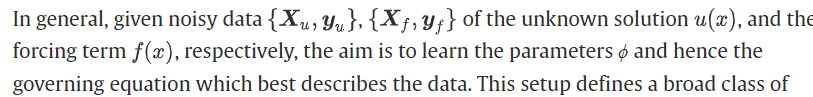

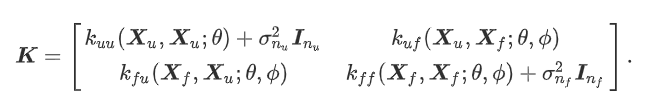

In [ ]:
# testing around
x = sp.symbols('x')
test_output = sp.diff(sp.sin(x), x)

In [ ]:
test_output

cos(x)

In [ ]:
# from OH, use sp.diff
# introduce new param gamma
# https://docs.sympy.org/latest/tutorials/intro-tutorial/calculus.html

# ∂2∂x2u(x)−γu(x)=f(x),  x∈[−1,1].
def operator(k, x, gamma):
    return sp.diff(k, x, 2) - gamma*k

In [ ]:
# Define kernels
# define symbols https://docs.sympy.org/latest/modules/core.html#symbols

x, xp = sp.symbols('x xp')
sigma, ell, gamma = sp.symbols('sigma ell gamma')

# adding gamma to the kernels
k_uu = sp.simplify(sigma*sp.exp(-0.5*(sp.Pow((x-xp)/ell,2)))) # cov matrix
k_uf = sp.simplify(operator(k_uu, xp, gamma))
k_ff = sp.simplify(operator(operator(k_uu, xp, gamma), x, gamma))

In [ ]:
k_uu

sigma*exp(-0.5*(x - xp)**2/ell**2)

In [ ]:
k_uf

sigma*(-ell**4*gamma - 1.0*ell**2 + (x - xp)**2)*exp(-0.5*(x - xp)**2/ell**2)/ell**4

In [ ]:
k_ff

sigma*(1.0*ell**6*gamma + ell**4*gamma*(ell**4*gamma + 1.0*ell**2 - (x - xp)**2) + ell**4*(-1.0*gamma*(x - xp)**2 + 2) + ell**2*(1.0*ell**2 - 5.0*(x - xp)**2) + 1.0*(-ell**2 + (x - xp)**2)*(x - xp)**2)*exp(-0.5*(x - xp)**2/ell**2)/ell**8

In [ ]:
k_uu_fn, k_uu_params = sympy2jax(k_uu, [x, xp, sigma, ell, gamma]) # add gamma
k_uf_fn, k_uf_params = sympy2jax(k_uf, [x, xp, sigma, ell, gamma])
k_ff_fn, k_ff_params = sympy2jax(k_ff, [x, xp, sigma, ell, gamma])

In [ ]:
# InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (3, 3, 5) and (3, 3, 1, 4)
# bump 4 to 5

def _k_uu(params, x, xp):
    sigma = np.exp(params[0:1])
    ell = np.exp(params[1:2])
    # add gamma
    gamma = params[2:3]
    inputs = np.concatenate([x, xp, sigma, ell, gamma]).reshape(1,5)
    return k_uu_fn(inputs, k_uu_params)[0]
    
def _k_uf(params, x, xp):
    sigma = np.exp(params[0:1])
    ell = np.exp(params[1:2])
    # add gamma
    gamma = params[2:3]
    inputs = np.concatenate([x, xp, sigma, ell, gamma]).reshape(1,5)
    return k_uf_fn(inputs, k_uf_params)[0]
    
def _k_ff(params, x, xp):
    sigma = np.exp(params[0:1])
    ell = np.exp(params[1:2])
    # add gamma
    gamma = params[2:3]
    inputs = np.concatenate([x, xp, sigma, ell, gamma]).reshape(1,5)
    return k_ff_fn(inputs, k_ff_params)[0]

In [ ]:
def vectorize(kernel):
    vec_fun = vmap(vmap(kernel, in_axes=(None,None,0)), in_axes=(None,0,None))
    return vec_fun

In [ ]:
k_uu_vec = jit(vectorize(_k_uu))
k_uf_vec = jit(vectorize(_k_uf))
k_ff_vec = jit(vectorize(_k_ff))

### GPR Helper Functions

In [ ]:
# A vectorized RBF kernel function
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

mu = lambda x: np.cos(4.0*np.pi*x)

In [ ]:
# A wrapper to call SciPy's L-BFGS-B optimizer
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [ ]:
# A minimal Gaussian process class
# Heavy modifications to consider xu,xf,yu,yf

class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF): 
        self.kernel = kernel_fn

    ######## modifications ########                    
    def random_init_GP(self, rng_key, dim):
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8) # 1e-8 stability perhaps?
        # logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))

        logsigma_nu = np.array([-4.0]) + random.normal(rng_key, (1,))
        logsigma_nf = np.array([-4.0]) + random.normal(rng_key, (1,))

        gamma = random.uniform(rng_key, shape = (1,))
        hyp = np.concatenate([logsigma_f, loglength, gamma, logsigma_nu, logsigma_nf])
        return hyp

    ######## modifications ########
    def compute_cholesky(self, params, batch):
        # X, _ = batch
        # N, D = X.shape

        Xu, Xf, yu, yf = batch
        Nu, _ = Xu.shape
        Nf, _ = Xf.shape

        # Fetch params
        # print(params.shape)
        # sigma_n = np.exp(params[-1])
        sigma_nf = np.exp(params[-1])
        sigma_nu = np.exp(params[-2])
        theta = np.exp(params[:-2])

        # Compute kernel
        # K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)

        # Generate samples
        # from GP_integral.ipynb

        K_uu = k_uu_vec(params, Xu, Xu) + np.eye(Nu) * (sigma_nu + 1e-8) # kernel/cov matrix for u(x), u(x)
        K_uf = k_uf_vec(params, Xu, Xf) # kernel/cov matrix for u(x), f(x)
        K_ff = k_ff_vec(params, Xf, Xf) + np.eye(Nf) * (sigma_nf + 1e-8) # kernel/cov matrix for f(x), f(x)

        # one giant cov matrix as seen in paper
        K = np.vstack((np.hstack((K_uu, K_uf)),np.hstack((K_uf.T, K_ff))))
        L = cholesky(K, lower=True)
        return L

    ######## modifications ########
    def likelihood(self, params, batch):
        # _, y = batch
        # N = y.shape[0]

        Xu, Xf, yu, yf = batch
        Nu, _ = Xu.shape
        Nf, _ = Xf.shape
        y = np.concatenate([yu, yf])
        N = Nu+Nf

        # Compute Cholesky
        L = self.compute_cholesky(params, batch)

        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    ######## modifications ########
    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        # X, _ = batch
        # dim = X.shape[1]
        
        Xu, Xf, yu, yf = batch
        Nu, Du = Xu.shape
        Nf, Df = Xf.shape
        # print(Nu, Du, Nf, Df) # 3 1 10 1

        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], Df) # replace D
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    ######## modifications ########

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        # X, y = batch
        Xu, Xf, yu, yf = batch
        Nu, _ = Xu.shape
        Nf, _ = Xf.shape

        # print(yu.shape) # (3, 1)
        # print(yf.shape) # (10, 1)
        y = np.concatenate([yu, yf])
        # print(y.shape) # (13, 1)

        # Fetch params
        # sigma_n = np.exp(params[-1])
        # theta = np.exp(params[:-1])
        sigma_nf = np.exp(params[-1])
        sigma_nu = np.exp(params[-2])
        theta = params[:-2] # rest of params

        # Compute kernels
        # calculate the covariance matrix of a Gaussian process model at a set of test inputs X_star
        # k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        # k_pX = self.kernel(X_star, X, theta)

        # kuu u(x)u(x), need diagonal
        k_uu_vec_pp = k_uu_vec(theta, X_star, X_star) + np.eye(X_star.shape[0]) * (sigma_nu + 1e-8)
        k_uu_vec_Xu = k_uu_vec(theta, X_star, Xu)

        # kuf u(x)f(x)
        k_uf_vec_Xf = k_uf_vec(theta, X_star, Xf)
        k_uf_vec_Xu = k_uf_vec(params, X_star, Xu)

        # kff - f(X)f(x), need diagonal
        k_ff_vec_pp = k_ff_vec(params, X_star, X_star) + np.eye(X_star.shape[0]) * (sigma_nf + 1e-8)
        k_ff_vec_Xf = k_ff_vec(params, X_star, Xf)

        k_pXu = np.column_stack((k_uu_vec_Xu, k_uf_vec_Xf))
        k_pXf = np.column_stack((k_uf_vec_Xu, k_ff_vec_Xf))
        L = self.compute_cholesky(params, batch)

        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        # beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        beta_u = solve_triangular(L.T,solve_triangular(L, k_pXu.T, lower=True))
        beta_f = solve_triangular(L.T, solve_triangular(L, k_pXf.T, lower=True))

        # Compute predictive mean, std
        # mu = np.matmul(k_pX, alpha)
        # cov = k_pp - np.matmul(k_pX, beta)
        # std = np.sqrt(np.clip(np.diag(cov), a_min=0.))

        mu_u = np.matmul(k_pXu, alpha) 
        cov_u = k_uu_vec_pp - np.matmul(k_pXu, beta_u)
        std_u = np.sqrt(np.clip(np.diag(cov_u), a_min=0.))

        mu_f = np.matmul(k_pXf, alpha)
        cov_f = k_ff_vec_pp - np.matmul(k_pXf, beta_f)
        std_f = np.sqrt(np.clip(np.diag(cov_f), a_min=0.))        


        # print(mu_u.shape) # (1001, 1)
        # print(std_u.shape) # (1001,)
        # print(mu_f.shape) # (1001, 1)
        # print(std_f.shape) # (1001,)

        # print(mu_u.flatten().shape) # (1001, 1)
        # print(mu_f.flatten().shape) # (1001, 1)

        return (mu_u, std_u), (mu_f, std_f)

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X, y = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample    

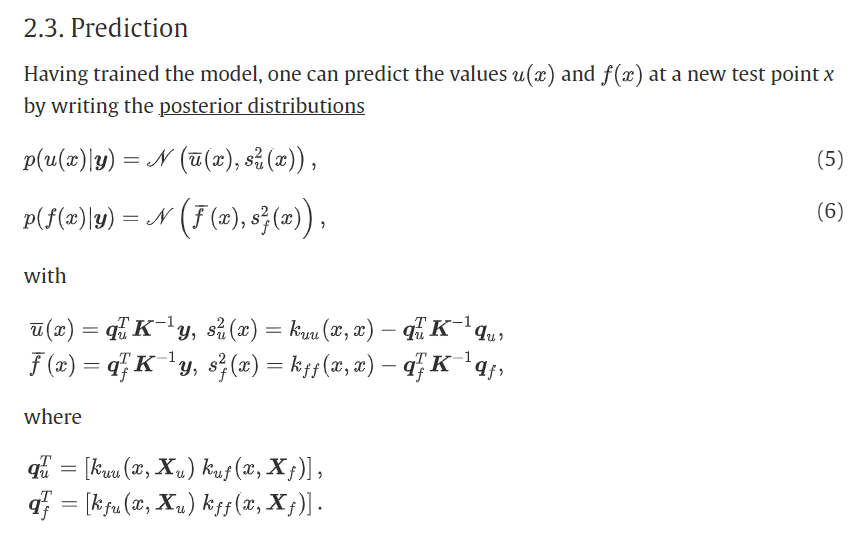

### Work

The exact solution for this problem is $u(x) = \sin(\pi x)$, corresponding to $f(x) = -\pi^2 \sin(\pi x) - \gamma \sin(\pi x)$.

In [ ]:
# exact solution
def u(x):
    return np.sin(np.pi*x)

# corresponding f(x)
def f(x):
    return -np.pi**2*np.sin(np.pi*x) - g*np.sin(np.pi*x)

In [ ]:
#  creating latin hypercube
# https://pythonhosted.org/pyDOE/randomized.html

# consider  γ=5√2 
g = 5*np.sqrt(2) # for f(x)

# generate a training data-set  {Xu,yu}  and  {Xf,yf}
# by sampling the exact solution for  u(x)  and  f(x)  
# use Nu=3  and  Nf=10  data points sampled randomly on a Latin Hypercube grid

Nu = 3
Nf = 10

# Training data
Xu = 2 * lhs(1, Nu) - 1
yu = u(Xu)

Xf = 2 * lhs(1, Nf) - 1
yf = f(Xf)

# Test data
# evaluate on x∈[−1,1].
X_star = np.linspace(-1, 1, 1001).reshape(-1, 1)
u_star = u(X_star).flatten() # flatten
f_star = f(X_star).flatten()

In [ ]:
model = GPRegression(kernel_fn = RBF)

### Plots 

Plot your predictions for  u(x)  and  f(x)  against the exact solution, and report their relative error in the  L2  norm. Also report the predicted value for $\gamma$ and the corresponding %-error with respect to the exact value of $5\sqrt{2}$.



In [ ]:
# Training:
opt_params = model.train((Xu, Xf, yu, yf), random.PRNGKey(12435))
(mu_u, std_u), (mu_f, std_f) = model.predict(opt_params, (Xu, Xf, yu, yf), X_star)

100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


In [ ]:
# getting high error with no flattening?
mu_u = mu_u.flatten()
mu_f = mu_f.flatten()

In [ ]:
# u(x) L2 relative error
np.linalg.norm((mu_u - u_star)/np.linalg.norm(u_star))

Array(1.74542801e-05, dtype=float64)

In [ ]:
# f(x) L2 relative error
np.linalg.norm((mu_f - f_star)/np.linalg.norm(f_star))

Array(4.85344101e-05, dtype=float64)

In [ ]:
# predicted gamma
opt_params[2]

Array(7.07134722, dtype=float64)

In [ ]:
# 5sqrt2, actual gamma
5 * np.sqrt(2)

Array(7.07106781, dtype=float64, weak_type=True)

In [ ]:
# % error with gamma w = 0.00071733 %
100 * (opt_params[2] - (5 * np.sqrt(2))) / (5 * np.sqrt(2))

Array(0.00395136, dtype=float64)

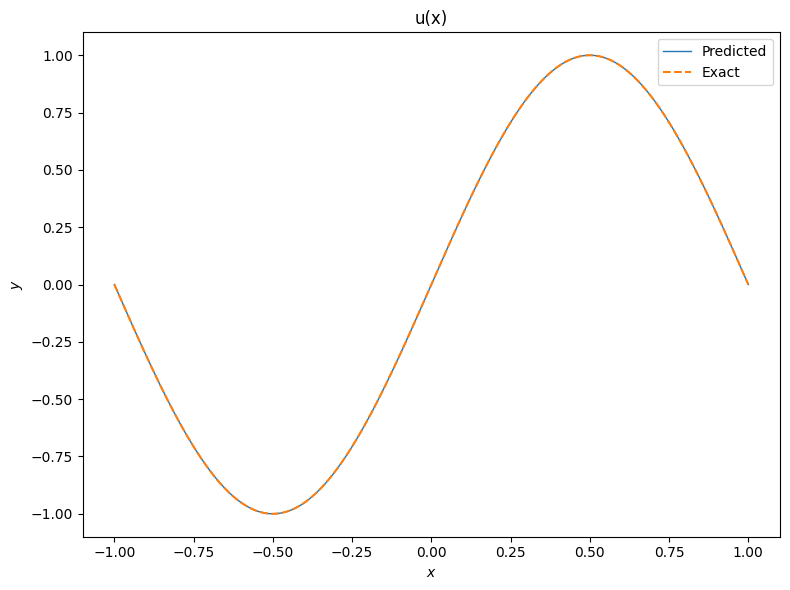

In [ ]:
# Plot
plt.figure(1, figsize=(8,6))
plt.plot(X_star, mu_u, linewidth=1.0, label = 'Predicted')
plt.plot(X_star.ravel(), u_star, '--', label = 'Exact')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('u(x)')
plt.tight_layout()

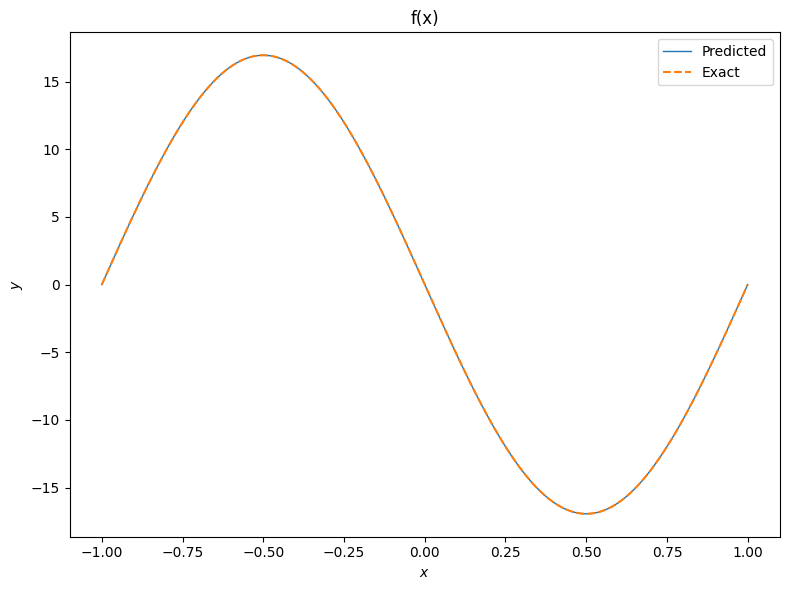

In [ ]:
# Plot
plt.figure(1, figsize=(8,6))
plt.plot(X_star, mu_f, linewidth=1.0, label = 'Predicted')
plt.plot(X_star.ravel(), f_star, '--', label = 'Exact')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('f(x)')
plt.tight_layout()